In [1]:
# Imports
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
# Starting and Ending dates for a particular stock
start_date = dt.datetime(2014,1,1)
end_date = dt.datetime(2020,12,31)

# INDIGO Stock for example (only NSE stock)
data = gh(symbol="INDIGO", start=start_date, end=end_date)

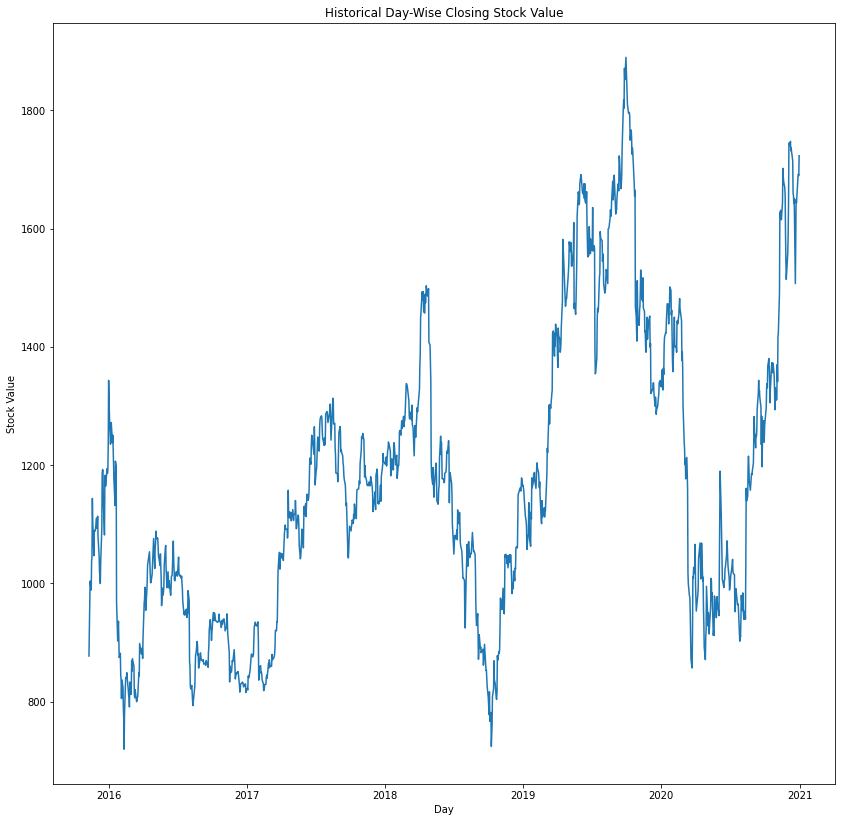

In [3]:
# Day wise closing prices
plt.figure(figsize=(14, 14))
plt.plot(data['Close'])
plt.title("Historical Day-Wise Closing Stock Value")
plt.xlabel("Day")
plt.ylabel("Stock Value")
plt.show()

In [4]:
data['Date'] = data.index  # Use the dates as the index
# Trim columns to the ones we're interested in
trimmed_data = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close'])
# Setting the dataframe's columns to the relevant data
trimmed_data['Date'] = data['Date']
trimmed_data['Open'] = data['Open']
trimmed_data['High'] = data['High']
trimmed_data['Low'] = data['Low']
trimmed_data['Close'] = data['Close']

In [6]:
# Preprocessing the data
# The above data is for training only, testing data comes later

# Normalization
training_set = trimmed_data.iloc[:, 1:2].values
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

X_train = []
Y_train = []

# Stamps of 60 with 1482 steps
for i in range(60, 1273):
    X_train.append(training_set_scaled[i-60:i, 0])
    Y_train.append(training_set_scaled[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

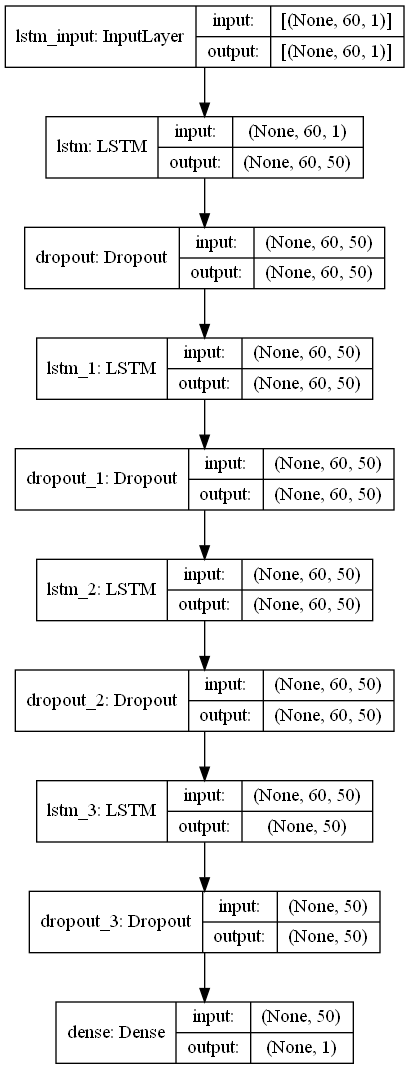

In [7]:
# LSTM Time!

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

keras.utils.plot_model(model, show_shapes=True)

In [8]:
# Train and compile the above model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=30, batch_size=32)

Epoch 1/30
38/38 [==============================] - 14s 69ms/step - loss: 0.0648
Epoch 2/30
38/38 [==============================] - 2s 60ms/step - loss: 0.0115
Epoch 3/30
38/38 [==============================] - 2s 59ms/step - loss: 0.0075
Epoch 4/30
38/38 [==============================] - 2s 62ms/step - loss: 0.0089
Epoch 5/30
38/38 [==============================] - 2s 61ms/step - loss: 0.0071
Epoch 6/30
38/38 [==============================] - 2s 63ms/step - loss: 0.0067
Epoch 7/30
38/38 [==============================] - 2s 63ms/step - loss: 0.0064
Epoch 8/30
38/38 [==============================] - 2s 63ms/step - loss: 0.0073
Epoch 9/30
38/38 [==============================] - 2s 62ms/step - loss: 0.0065
Epoch 10/30
38/38 [==============================] - 2s 62ms/step - loss: 0.0058
Epoch 11/30
38/38 [==============================] - 2s 64ms/step - loss: 0.0055
Epoch 12/30
38/38 [==============================] - 2s 63ms/step - loss: 0.0051
Epoch 13/30
38/38 [=================

In [42]:
# Now to test the trained model on real world data
# We follow the same data gathering procedure and get data from a different time period in the future

test_start = dt.datetime(2021,1,1)
test_end = dt.datetime(2021,7,31)
test_data = gh(symbol="INDIGO", start=test_start, end=test_end)

test_data['Date'] = test_data.index  # Use the dates as the index
test_dataframe = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close'])
test_dataframe['Date'] = test_data['Date']
test_dataframe['Open'] = test_data['Open']
test_dataframe['High'] = test_data['High']
test_dataframe['Low'] = test_data['Low']
test_dataframe['Close'] = test_data['Close']

real_price = test_dataframe.iloc[:, 1:2].values
dataset_total = pd.concat((trimmed_data['Open'], test_dataframe['Open']), axis=0)

inputs = dataset_total[len(dataset_total) - len(test_dataframe) - 60:].values
inputs = inputs.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
inputs = scaler.fit_transform(inputs)

X_test = []

for i in range(60, 204):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

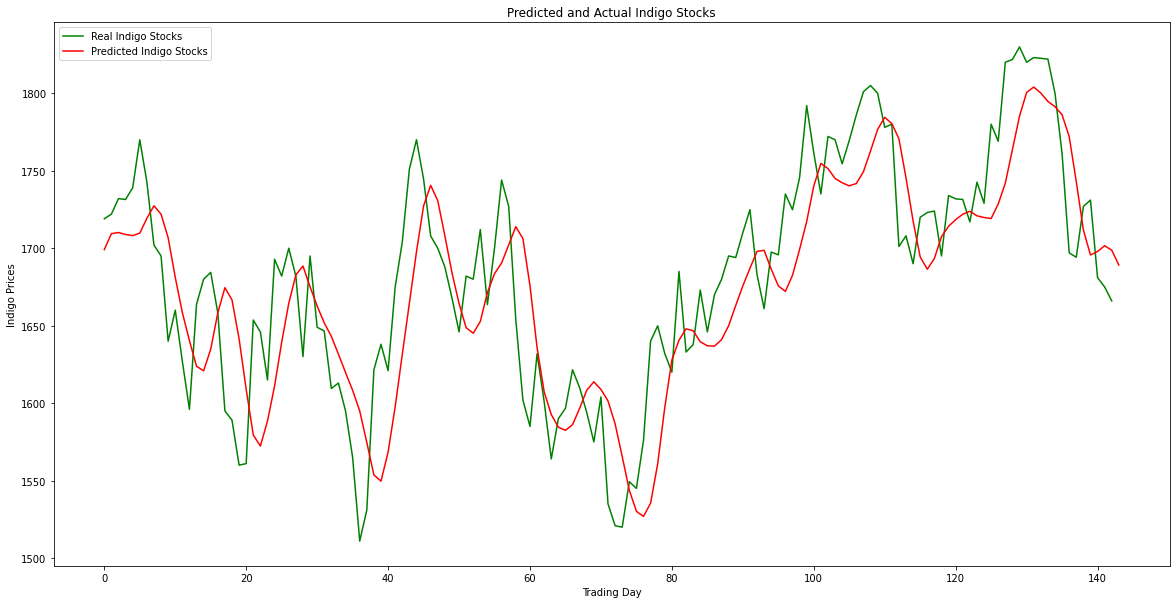

In [45]:
# Test the model on real world data
# Also plot the difference between predicted and actual prices

predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

plt.figure(figsize=(20, 10))
plt.plot(real_price, color="green", label="Real Indigo Stocks")
plt.plot(predicted_price, color="red", label="Predicted Indigo Stocks")
plt.title("Predicted and Actual Indigo Stocks")
plt.xlabel("Trading Day")
plt.ylabel("Indigo Prices")
plt.legend()
plt.show()

In [ ]:
# One Step Ahead Predictions

# TODO